### Names: Shabbir Hussain, Humaira Fasih Ahmed 
### Roll Numbers: 24100240, 24100059
### Project Name: Wildlife Monitoring

Data and Weights link: https://1drv.ms/f/s!AteW8yofIdjxhHRNS3UUQHQdL9Af?e=NmKBVS

### Final Submission

1. Previously our model made errors when the image belonged to a specie which occured less in the dataset. To resolve this issue we added classification layer to force our model to learn features relating to all species in the dataset.

2. Adding the classification loss to the overall loss also stopped the model from overfitting to the training data.

3. The model was trained for ~75 epochs however only 50 epochs have been shown in the output.

3. Reported the BLEU-1,2,3,4 over the entire dataset.

Instructions:

1. Place 'Dataset' and 'weights' folder in the same directory as this file
2. Make sure you have all the neccessary libraries installed, including torchtext for calculating BLEU scores.
2. The command to save model weights has been commented out in order to avoid overwriting the saved weights
3. Before running the model on other images from Serengeti Dataset, captions_classes.txt file needs to be generated that contains path of each image, the corresponding caption and the specie name. Otherwise the data will not be loaded.


In [4]:
# Importing libraries
import os
import gc
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn
import torchvision.models as models
from torchvision.transforms import transforms
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchtext.data.metrics import bleu_score

import warnings
warnings.filterwarnings("ignore")

In [5]:
# Vocabulary Class
class Vocab():
    def __init__(self):
        self.int_to_str = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"} # Integer to string
        self.str_to_int = {v: k for k, v in self.int_to_str.items()} # String to integer

    def __len__(self):
        return len(self.int_to_str)
    
    def token_generator(self, text):
        return [word.lower() for word in text.split()]
    
    def build_vocab(self, sentence_list):
        idx = 4 # index 0, 1, 2, 3 are reserved for special tokens
        
        for sentence in sentence_list:
            for word in self.token_generator(sentence): # Assigning ids to words
                if word in self.str_to_int:
                    continue
                self.str_to_int[word] = idx
                self.int_to_str[idx] = word
                idx += 1

    def numericalize(self, text):
        tokenized_text = self.token_generator(text)
        return [self.str_to_int[token] if token in self.str_to_int else self.str_to_int["<UNK>"] for token in tokenized_text]

# Dataset Class
class WildlifeDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None):
        self.root_dir = root_dir
        self.captions_df = pd.read_csv(captions_file)
        self.transform = transform

        # Get the images, captions, and their respective classes
        self.imgs, self.captions, self.classes = self.captions_df['image'], self.captions_df['caption'], self.captions_df['class']

        # Create the vocabulary
        self.vocab = Vocab()
        self.vocab.build_vocab(self.captions.tolist())

    def __len__(self):
        return len(self.captions)
    
    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        classes = self.classes[index]
        classes_labels = ['ostrich', "Thomson's gazelle", 'zebra', 'hare', 'bird', 'vervet monkey', 'male lion', 'female lion', 'dik dik', 'cheetah', 'giraffe', 'waterbuck', 'jackal', 'wildebeest', 'eland', 'kori bustard', 'impala', 'spotted hyena', 'elephant', 'bat-eared fox', "Grant's gazelle", 'hippopotamus', 'reedbuck', 'secretarybird', 'topi', 'buffalo', 'warthog', 'hartebeest', 'mongoose', 'baboon', 'serval', 'guinea fowl']
        classes = classes_labels.index(classes) # convert to index of classes labels

        img_path = os.path.join(self.root_dir, img_id)
        
        if not os.path.exists(img_path):
          return self.__getitem__(index+1)
    
        img = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        # Convert caption (string) to numericalized tokens
        caption = [self.vocab.str_to_int["<SOS>"]] + self.vocab.numericalize(caption) + [self.vocab.str_to_int["<EOS>"]]
        caption = torch.tensor(caption)

        return img, caption, classes

# Collater for the DataLoader
class Collate():
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx # index of the padding token

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)

        targets = [item[1] for item in batch]
        targets = nn.utils.rnn.pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        classes = [item[2] for item in batch]
        classes = torch.tensor(classes)

        return imgs, targets, classes


In [6]:
class Encoder(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(Encoder, self).__init__()
        self.train_CNN = train_CNN
        self.inception = models.inception_v3(pretrained=True)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, embed_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.classifier = nn.Linear(embed_size, 32)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, images, train_status=True):
        if train_status:
            features, _ = self.inception(images)
        else:
            features  = self.inception(images)
        # pass features to decoder as well as use them for classification
        features = self.dropout(self.relu(features))
        classification = self.classifier(features)
        classification = self.softmax(classification)
        return features, classification


class Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(Decoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs          

class ImageCaptionModel(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super().__init__()
        self.encoder = Encoder(embed_size)
        self.decoder = Decoder(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        if self.training:
          features, classification = self.encoder(images)
          out = self.decoder(features, captions)
        else:
          features, classification = self.encoder(images, False)
          out = self.decoder(features, captions)
        return out, classification

    def caption_image(self, image, vocabulary, max_len=30):
        result_caption = []

        with torch.no_grad():
            x, _ = self.encoder(image, False)
            x =  x.unsqueeze(0)
            states = None
            for _ in range(max_len):
                hiddens, states = self.decoder.lstm(x, states)
                output = self.decoder.linear(hiddens.squeeze(1)) 
                predicted = output.argmax(1)
                result_caption.append(predicted.item())
                x = self.decoder.embed(predicted).unsqueeze(0)
                if vocabulary.int_to_str[predicted.item()] == "<EOS>":
                    break
        return [vocabulary.int_to_str[idx] for idx in result_caption]

In [7]:
# Creating Dataset and Dataloader
dataset_root = 'Dataset'
caption_dir = 'Dataset/captions_classes.txt'

dataset = WildlifeDataset(root_dir=dataset_root, captions_file=caption_dir, transform=transforms.Compose([transforms.Resize(356), transforms.CenterCrop(356), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
dataset_display = WildlifeDataset(root_dir=dataset_root, captions_file=caption_dir, transform=transforms.Compose([transforms.Resize(356), transforms.ToTensor()]))

pad_idx = dataset.vocab.str_to_int["<PAD>"]
train_set, test_set = torch.utils.data.random_split(dataset, [int(len(dataset)*0.85), len(dataset) - int(len(dataset)*0.85)])
train_loader = DataLoader(
        dataset=train_set,
        batch_size=64,
        shuffle=True,
        pin_memory=True,
        collate_fn=Collate(pad_idx=pad_idx)
    )
test_loader = DataLoader(
        dataset=test_set,
        batch_size=64,
        shuffle=True,
        pin_memory=True,
        collate_fn=Collate(pad_idx=pad_idx)
    )

In [8]:
# Clearing GPU memory
gc.collect()
with torch.no_grad():
  torch.cuda.empty_cache()

In [11]:
# Hyperparameters
embed_size = 256
hidden_size = 256
vocab_size = len(dataset.vocab)
num_layers = 1
learning_rate = 2e-4
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate model
model = ImageCaptionModel(embed_size, hidden_size, vocab_size, num_layers).to(device)

# Initialize loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.str_to_int["<PAD>"])
criterion_class = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
weights_file = 'weights/model.pth'
model.load_state_dict(torch.load(weights_file))

<All keys matched successfully>

In [7]:
def train(model, train_loader, criterion, criterion_class, optimizer, num_epochs,device):
    model.train()
    epoch_losses = []

    for epoch in range(num_epochs):

        epoch_loss = 0
        class_loss = 0
        epoch_start = time.time()

        for imgs, captions, classes in train_loader:

            # Move data to device
            imgs = imgs.to(device)
            captions = captions.to(device)
            classes = classes.to(device)
            
            # Forward propagation
            outputs, classification_outputs = model(imgs, captions[:-1])
            
            # Loss calculation
            classes_one_hot = torch.nn.functional.one_hot(classes, num_classes=32).to(device)
            classification_loss = criterion_class(classification_outputs, classes_one_hot.float())
            class_loss += classification_loss.item()
            loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)) + classification_loss
            
            # Backpropagation  
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            
        print(f"Epoch {epoch+1} finished in {(time.time()-epoch_start):.2f} seconds...")
        print(f"Epoch [{epoch + 1}/{num_epochs}], Overall Loss: {epoch_loss / len(train_loader):.4f}")
        print(f"Epoch [{epoch + 1}/{num_epochs}], Caption Loss: {(epoch_loss - class_loss)/ len(train_loader):.4f}")
        print(f"Epoch [{epoch + 1}/{num_epochs}], Classification Loss: {class_loss / len(train_loader):.4f}")
        print('-'*20)
        epoch_losses.append(epoch_loss/len(train_loader))
    return epoch_losses

losses = train(model, train_loader=train_loader, criterion=criterion,criterion_class = criterion_class, optimizer=optimizer,num_epochs=num_epochs,device=device)

Epoch 1 finished in 284.49 seconds...

Epoch [1/50], Overall Loss: 3.0813

Epoch [1/50], Caption Loss: 0.3343

Epoch [1/50], Classification Loss: 2.7470

--------------------

Epoch 2 finished in 233.16 seconds...

Epoch [2/50], Overall Loss: 3.0702

Epoch [2/50], Caption Loss: 0.3265

Epoch [2/50], Classification Loss: 2.7436

--------------------

Epoch 3 finished in 233.67 seconds...

Epoch [3/50], Overall Loss: 3.0559

Epoch [3/50], Caption Loss: 0.3166

Epoch [3/50], Classification Loss: 2.7393

--------------------

Epoch 4 finished in 234.12 seconds...

Epoch [4/50], Overall Loss: 3.0297

Epoch [4/50], Caption Loss: 0.3097

Epoch [4/50], Classification Loss: 2.7200

--------------------

Epoch 5 finished in 232.97 seconds...

Epoch [5/50], Overall Loss: 2.9989

Epoch [5/50], Caption Loss: 0.3054

Epoch [5/50], Classification Loss: 2.6935

--------------------

Epoch 6 finished in 231.60 seconds...

Epoch [6/50], Overall Loss: 2.9800

Epoch [6/50], Caption Loss: 0.3021

Epoch [6/

In [ ]:
# Saving the model weights 

# torch.save(model.state_dict(), weights_file)

Text(0, 0.5, 'Loss')

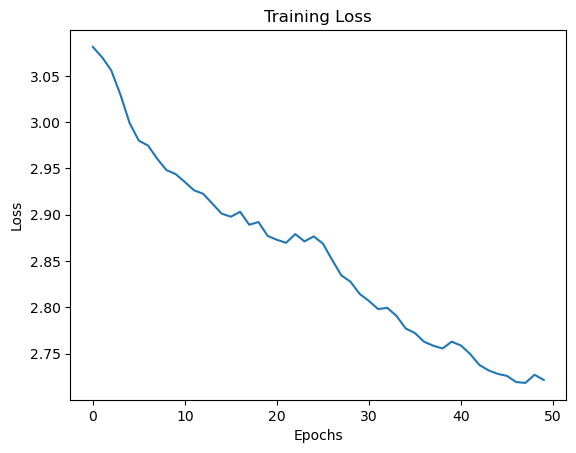

In [8]:
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [9]:
model.eval()
with torch.no_grad():
    test_loss = 0.0
    class_loss = 0
    for imgs, captions, classes in test_loader:
        imgs = imgs.to(device)
        captions = captions.to(device)
        classes = classes.to(device)
        outputs, classification_outputs = model(imgs, captions[:-1])
        classes_one_hot = torch.nn.functional.one_hot(classes, num_classes=32).to(device)
        classification_loss = criterion_class(classification_outputs, classes_one_hot.float())
        class_loss += classification_loss
        loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)) + classification_loss
        test_loss+=loss

print(f"Test Caption Loss: {test_loss/len(test_loader):.4f}")
print(f"Caption Loss: {(test_loss - class_loss)/ len(test_loader):.4f}")
print(f"Class Loss: {class_loss / len(test_loader):.4f}")

Test Caption Loss: 2.8599

Caption Loss: 0.2214

Class Loss: 2.6385


In [32]:
model.eval()
all_pred = []
all_act = []
for idx in range(len(dataset)):
    img, caption, _ = dataset[idx]

    # Predicting Caption
    pred = model.caption_image(img.unsqueeze(0).to(device), dataset.vocab)
    all_pred.append(pred)
    caption_decoded = []
    for word_idx in caption:
        caption_decoded.append(dataset.vocab.int_to_str[int(word_idx)])
    all_act.append([caption_decoded])

bleu_1_score = bleu_score(all_pred, all_act, max_n=1, weights=(1.0,))
bleu_2_score = bleu_score(all_pred, all_act, max_n=2, weights=(0.5, 0.5))
bleu_3_score = bleu_score(all_pred, all_act, max_n=3, weights=(0.33, 0.33, 0.33))
bleu_4_score = bleu_score(all_pred, all_act, max_n=4, weights=(0.25, 0.25, 0.25, 0.25))


print("BLEU-1 score over the entire dataset: ", bleu_1_score)
print("BLEU-2 score over the entire dataset: ", bleu_2_score)
print("BLEU-3 score over the entire dataset: ", bleu_3_score)
print("BLEU-4 score over the entire dataset: ", bleu_4_score)

BLEU-1 score over the entire dataset:  0.9313777663096084
BLEU-2 score over the entire dataset:  0.9004411297229316
BLEU-3 score over the entire dataset:  0.8658755091948893
BLEU-4 score over the entire dataset:  0.8372741890588865


[Generated Caption]: <SOS> many buffalos are moving and eating . <EOS>
[Actual Caption]: <SOS> many buffalos are moving and eating with young . <EOS>


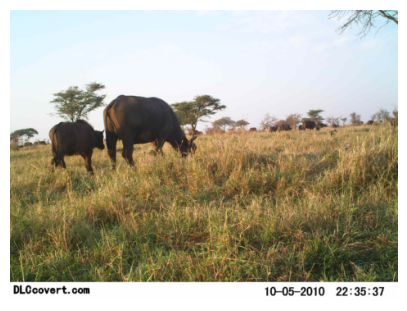



[Generated Caption]: <SOS> an impala is moving . <EOS>
[Actual Caption]: <SOS> an impala is moving . <EOS>


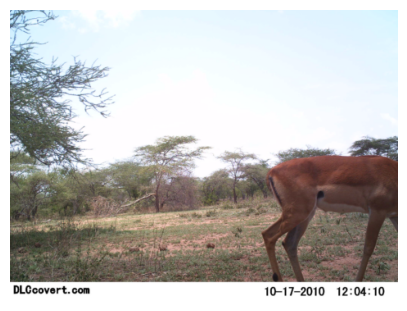



[Generated Caption]: <SOS> a pair of dik dik is standing . <EOS>
[Actual Caption]: <SOS> a pair of dik dik is standing . <EOS>


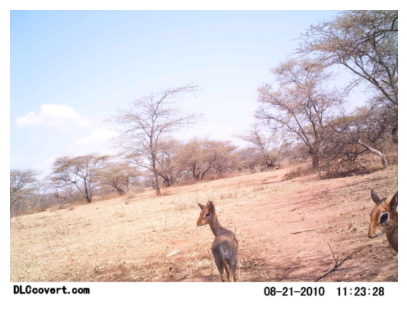



[Generated Caption]: <SOS> a few reedbucks are standing and resting and eating . <EOS>
[Actual Caption]: <SOS> a few reedbucks are standing and resting and eating . <EOS>


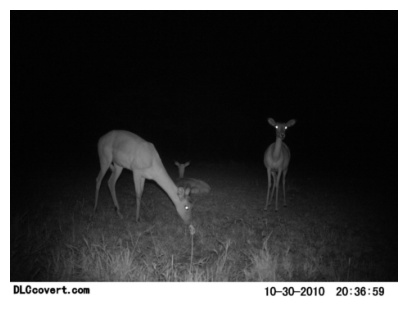



[Generated Caption]: <SOS> an impala is moving . <EOS>
[Actual Caption]: <SOS> an impala is eating . <EOS>


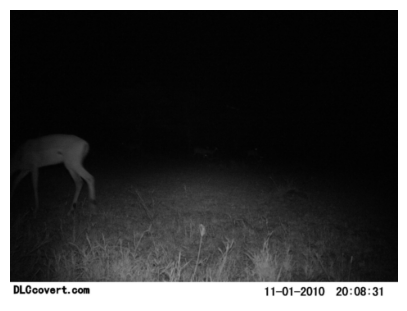



[Generated Caption]: <SOS> a pair of thomson's gazelle is standing . <EOS>
[Actual Caption]: <SOS> a pair of thomson's gazelle is standing . <EOS>


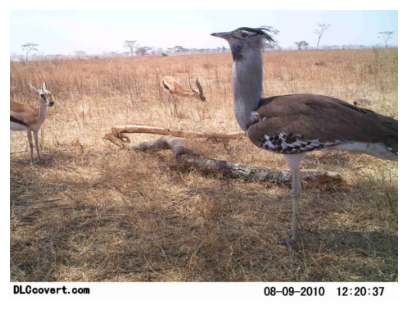



[Generated Caption]: <SOS> an impala is moving . <EOS>
[Actual Caption]: <SOS> an impala is moving . <EOS>


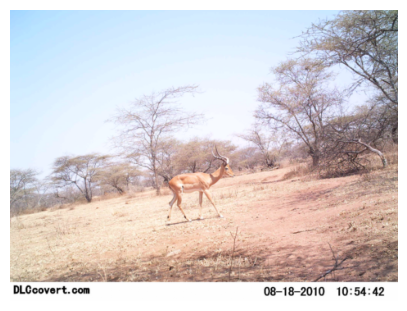



[Generated Caption]: <SOS> a reedbuck is standing . <EOS>
[Actual Caption]: <SOS> a reedbuck is standing . <EOS>


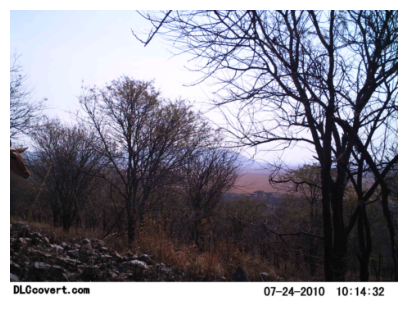



[Generated Caption]: <SOS> an ostrich is moving . <EOS>
[Actual Caption]: <SOS> an ostrich is moving . <EOS>


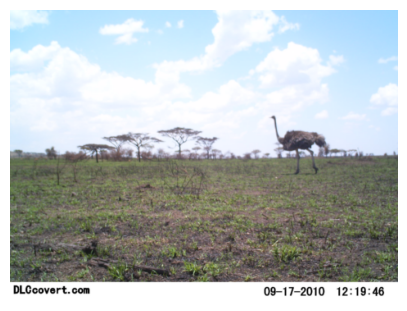



[Generated Caption]: <SOS> many buffalos are standing and resting . <EOS>
[Actual Caption]: <SOS> many buffalos are standing and resting and eating . <EOS>


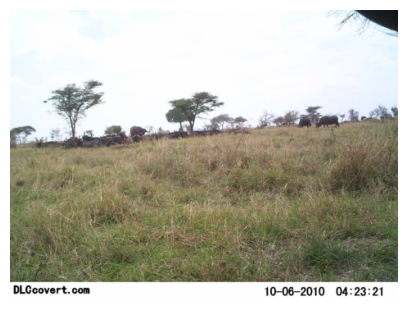



[Generated Caption]: <SOS> a pair of warthog is moving . <EOS>
[Actual Caption]: <SOS> a pair of warthog is moving with young . <EOS>


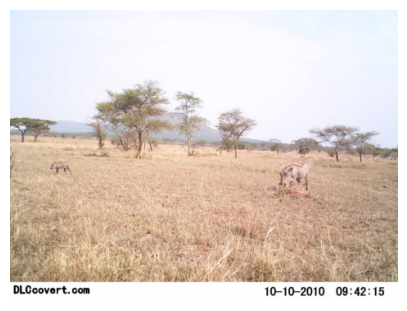



[Generated Caption]: <SOS> a grant's gazelle is moving . <EOS>
[Actual Caption]: <SOS> a grant's gazelle is moving . <EOS>


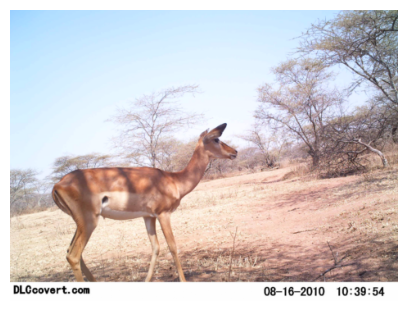



[Generated Caption]: <SOS> a giraffe is standing . <EOS>
[Actual Caption]: <SOS> a giraffe is moving . <EOS>


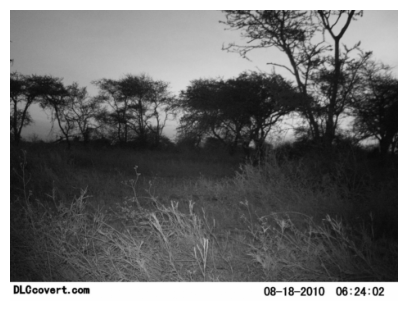



[Generated Caption]: <SOS> a pair of warthog is moving . <EOS>
[Actual Caption]: <SOS> a pair of warthog is moving . <EOS>


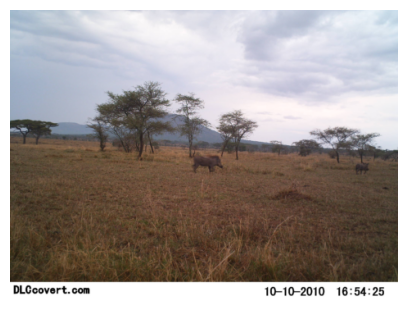



[Generated Caption]: <SOS> a giraffe is moving . <EOS>
[Actual Caption]: <SOS> a giraffe is moving . <EOS>


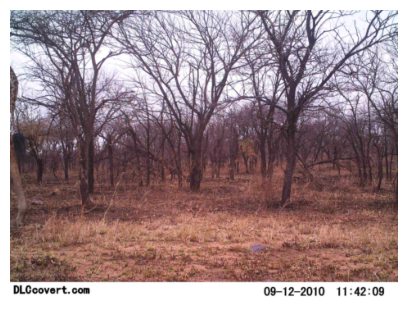

In [14]:
model.eval()
num_of_imgs = 15 # number of images to display during evaluation

for i in range(num_of_imgs):
    
    # Get a random image
    idx = np.random.randint(0, len(dataset))
    img, caption, _ = dataset[idx]
    disp_img, _, _ = dataset_display[idx]

    # Predicting Caption
    pred = model.caption_image(img.unsqueeze(0).to(device), dataset.vocab)
    print(f"[Generated Caption]: {' '.join(pred)}")
    caption_decoded = []
    for word_idx in caption:
        caption_decoded.append(dataset.vocab.int_to_str[int(word_idx)])
    print(f"[Actual Caption]: {' '.join(caption_decoded)}")
    
    # Displaying Image
    fig = plt.figure(figsize=(5, 5))
    plt.imshow(disp_img.permute(1, 2, 0))
    plt.axis('off')
    plt.show()
    print('\n')